In [1]:
!pip install prophet


# 1. Import libraries

In [2]:
#import needed libs
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
import numpy as np
import matplotlib.dates as mdates
from prophet import Prophet


# 2. Uploading and preparing the data 

In [3]:
#data_set.  Clean data WITHOUT outliers 
df = pd.read_csv('data_no_outliers.csv')
df = df.set_index('Txn_date')
df.index = pd.to_datetime(df.index)
df = df.sort_index()


In [4]:

df_sorted = df.sort_values("Total_Amt")
df_sorted.head()

,Invoice_id,Cust_id,Product_Sub_category,Product_Category,Qty,Rate,Tax,Total_Amt,Store_type
Txn_date,,,,,,,,,
2017-04-29,6409679426,267504,Kids,Footwear,1,70,7.350,77.350,TeleShop
2018-08-18,41885435954,272238,Kids,Books,1,70,7.350,77.350,TeleShop
2018-01-16,20826996132,271969,Kids,Clothing,1,70,7.350,77.350,e-Shop
2018-04-07,77308601183,268879,Mens,Clothing,1,71,7.455,78.455,Brick and Mortar
2018-12-27,16380694071,268284,Mens,Bags,1,71,7.455,78.455,e-Shop


In [5]:
#resample
df_daily = df.resample('D').sum().reset_index()


/var/folders/wd/2sf_363j2qgdyy46qr3rysph0000gn/T/ipykernel_84638/214196941.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_daily = df.resample('D').sum().reset_index()


In [6]:
df_daily.head()

,Txn_date,Invoice_id,Cust_id,Qty,Rate,Tax,Total_Amt
0,2016-01-02,1107788615825,6220887,72,17305,5713.155,60124.155
1,2016-01-03,742164348049,3252878,40,7996,3108.315,32711.315
2,2016-01-04,1146571949749,6213473,75,18683,6595.155,69406.155
3,2016-01-05,879331792460,5955886,69,17788,5741.820,60425.820
4,2016-01-06,788980970651,4582807,50,14008,3974.775,41829.775


In [7]:
#checking for negative and zero values:
zero = (df_daily['Total_Amt'] == 0).any()
negatives = (df_daily['Total_Amt'] < 0).any()

print(zero)
print(negatives)

True
False


In [8]:
#rename columns
df_prophet = df_daily.rename(columns={'Txn_date': 'ds', 'Total_Amt': 'y'})


# 3. Model, Forecasting. Two options: 
#1 - Daily_seasonality, changepoint, holidays (US). 
#2 - Daily_seasonality, changepoint ONLY!

In [9]:
##1 - Daily_seasonality, changepoint, holidays (US).
# run this if holidays needed to be included!
m = Prophet(daily_seasonality=False, changepoint_prior_scale=0.1)
m.add_seasonality(name='weekly', period=7, fourier_order=3)
m.add_country_holidays(country_name='US')
m.fit(df_prophet)

16:19:27 - cmdstanpy - INFO - Chain [1] start processing
16:19:27 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
#2 - Daily_seasonality, changepoint ONLY!


m = Prophet(daily_seasonality=True, changepoint_prior_scale=0.1)

# adding custom weekly seasonality
m.add_seasonality(name='weekly', period=7, fourier_order=3)

# fit the model
m.fit(df_prophet)

16:19:27 - cmdstanpy - INFO - Chain [1] start processing
16:19:27 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
#creating df to hold prediction
future = m.make_future_dataframe(periods=365) #  next year


In [12]:
#Prediction
forecast = m.predict(future)


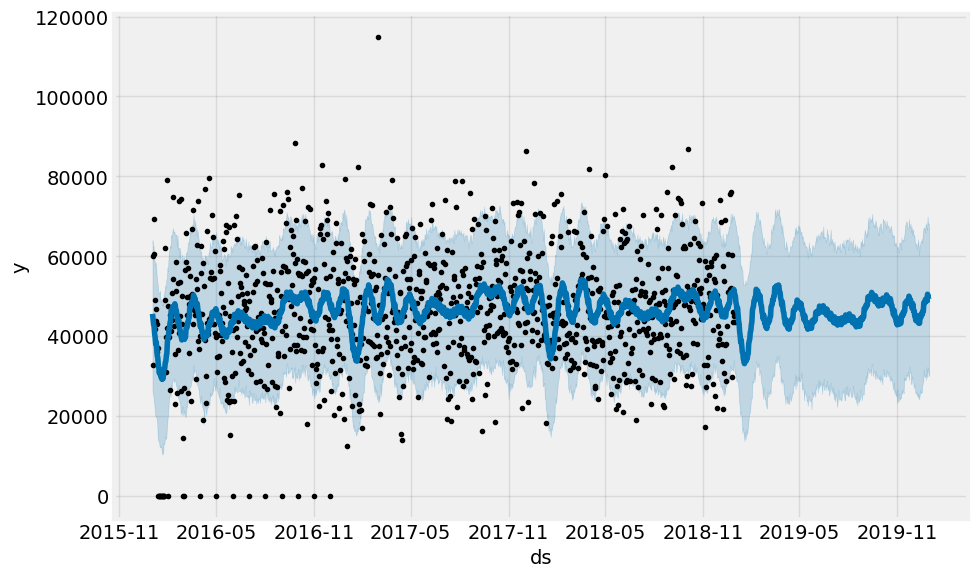

In [13]:
#plot the forecast
fig1 = m.plot(forecast)


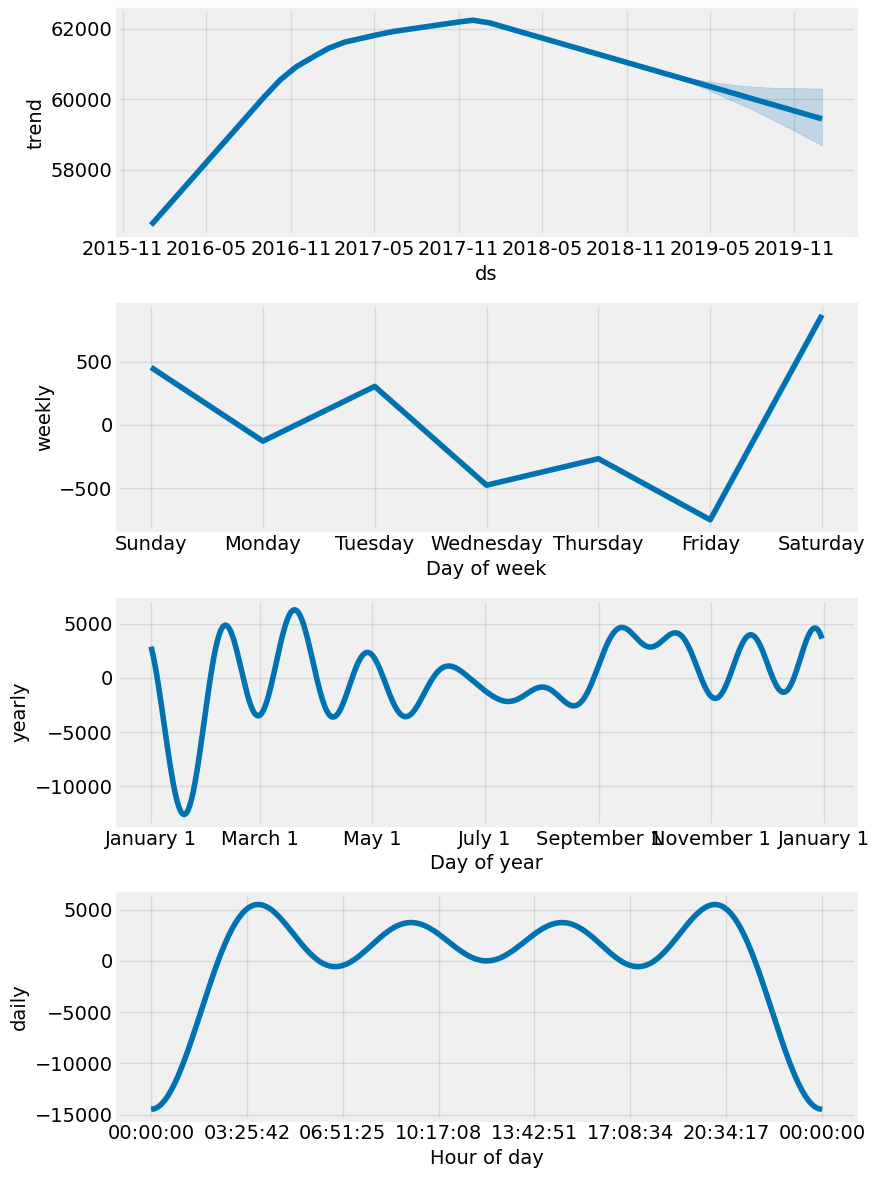

In [14]:
fig2 = m.plot_components(forecast)


In [15]:
# Initialize a dictionary to store the models
models = {}

# 4. Forecast by category

In [16]:
# categories
unique_categories = df['Product_Category'].unique()
unique_categories

array(['Electronics', 'Books', 'Clothing', 'Home and kitchen', 'Footwear',
       'Bags'], dtype=object)

In [17]:
for category in unique_categories:
    # Filter the data
    df_filtered = df[df['Product_Category'] == category]
    df_daily = df_filtered.resample('D').sum().reset_index()
    
    df_prophet = df_daily.rename(columns={'Txn_date': 'ds', 'Total_Amt': 'y'})

    # Initialize and fit the model
    m = Prophet(daily_seasonality=True)
    m.fit(df_prophet)

    # Store the model
    models[category] = m

/var/folders/wd/2sf_363j2qgdyy46qr3rysph0000gn/T/ipykernel_84638/1178625639.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_daily = df_filtered.resample('D').sum().reset_index()
16:19:28 - cmdstanpy - INFO - Chain [1] start processing
16:19:28 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/wd/2sf_363j2qgdyy46qr3rysph0000gn/T/ipykernel_84638/1178625639.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_daily = df_filtered.resample('D').sum().reset_index()
16:19:29 - cmdstanpy - INFO - Chain [1] start processing
16:19:29 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/wd/2sf_

In [18]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-02,56436.605454,26525.163457,63954.388269,56436.605454,56436.605454,-10901.704936,-10901.704936,-10901.704936,-14492.976362,...,868.815179,868.815179,868.815179,2722.456247,2722.456247,2722.456247,0.0,0.0,0.0,45534.900518
1,2016-01-03,56451.411053,25264.555322,62176.678996,56451.411053,56451.411053,-12087.129597,-12087.129597,-12087.129597,-14492.976362,...,454.245183,454.245183,454.245183,1951.601582,1951.601582,1951.601582,0.0,0.0,0.0,44364.281456
2,2016-01-04,56466.216652,24642.260821,62543.349205,56466.216652,56466.216652,-13555.112886,-13555.112886,-13555.112886,-14492.976362,...,-129.175807,-129.175807,-129.175807,1067.039283,1067.039283,1067.039283,0.0,0.0,0.0,42911.103766
3,2016-01-05,56481.022251,23100.536451,59593.260680,56481.022251,56481.022251,-14106.727489,-14106.727489,-14106.727489,-14492.976362,...,303.759703,303.759703,303.759703,82.489170,82.489170,82.489170,0.0,0.0,0.0,42374.294762
4,2016-01-06,56495.827850,22256.600661,58675.984842,56495.827850,56495.827850,-15956.191866,-15956.191866,-15956.191866,-14492.976362,...,-477.709522,-477.709522,-477.709522,-985.505982,-985.505982,-985.505982,0.0,0.0,0.0,40539.635984


In [19]:
# Initialize a dictionary to store the forecasts
forecasts = {}

for category, model in models.items():
    # Create future dataframe
    future = model.make_future_dataframe(periods=365)

    # Predict
    forecast = model.predict(future)

    # Store the forecast
    forecasts[category] = forecast


Forecast for category: Electronics


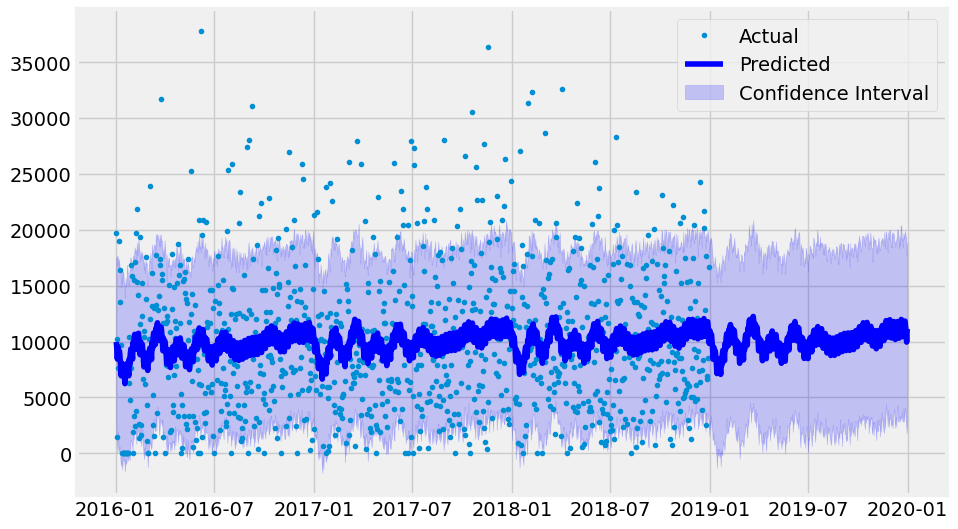

Forecast for category: Books


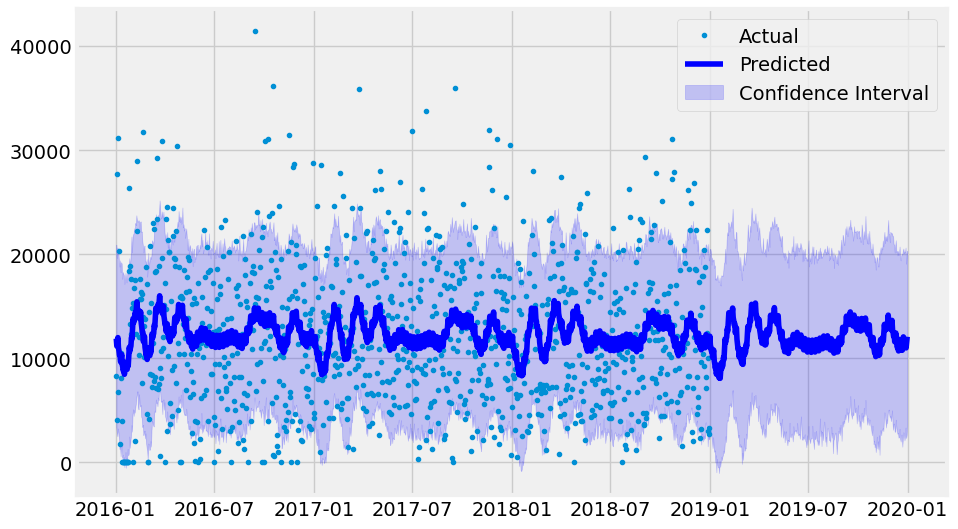

Forecast for category: Clothing


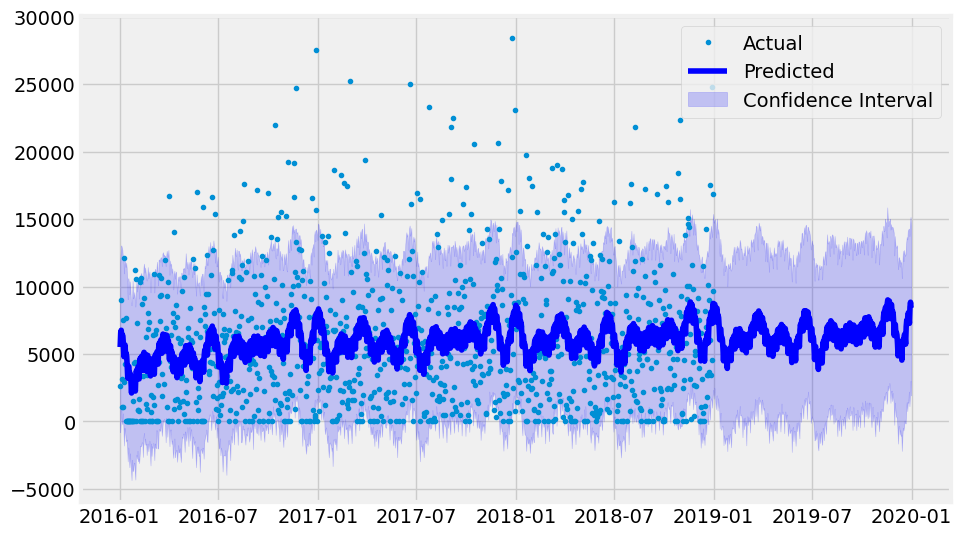

Forecast for category: Home and kitchen


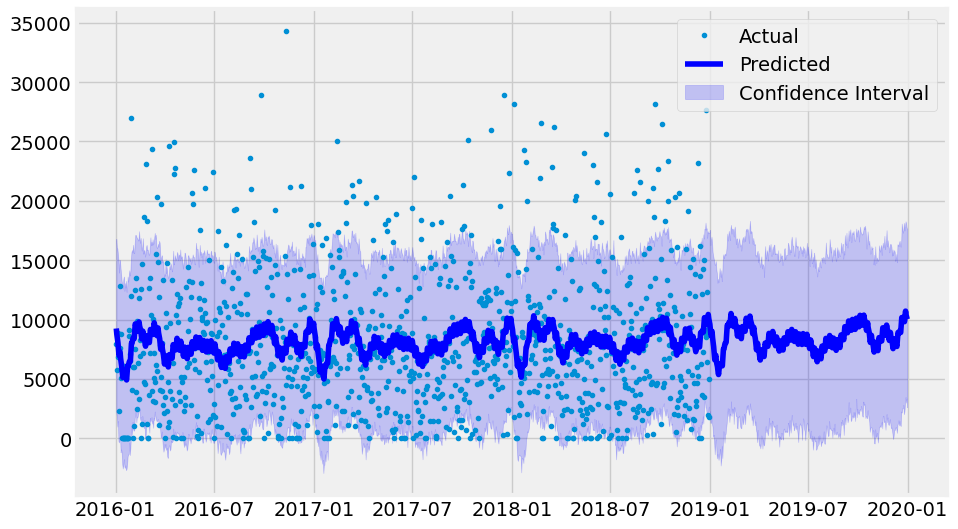

Forecast for category: Footwear


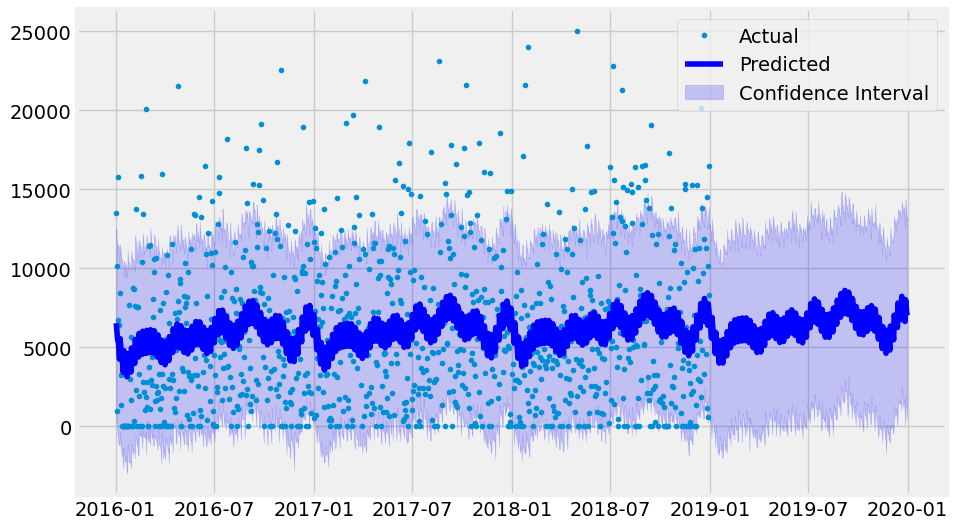

Forecast for category: Bags


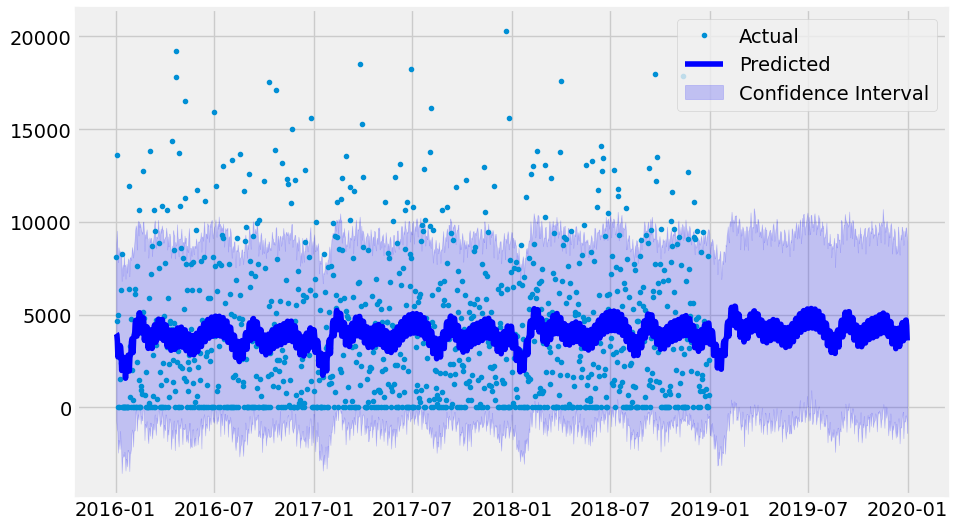

In [20]:
#Forecast for each category:

for category, forecast in forecasts.items():
    print(f"Forecast for category: {category}")
    model = models[category]
    
    fig = plt.figure(facecolor='w', figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.plot(model.history['ds'], model.history['y'], '.', label='Actual')
    ax.plot(forecast['ds'], forecast['yhat'], ls='-', c='blue', label='Predicted')
    ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label='Confidence Interval')
    ax.legend(loc='best')
    plt.show()  


# 5. Merging two data frames: ''df_daily'' and ''forecast''

In [21]:
df_daily.head()

,Txn_date,Invoice_id,Cust_id,Qty,Rate,Tax,Total_Amt
0,2016-01-02,117643988025,546297,9,1574,770.595,8109.595
1,2016-01-03,30501471458,270632,5,847,444.675,4679.675
2,2016-01-04,146194651928,813260,13,2827,1295.280,13631.280
3,2016-01-05,32992559875,274470,4,1125,472.500,4972.500
4,2016-01-06,0,0,0,0,0.000,0.000


In [22]:
#merging two df's
merged = df_daily.join(forecast[['yhat', 'yhat_lower', 'yhat_upper']], how = 'inner')


In [23]:
merged[['Total_Amt', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,Total_Amt,yhat,yhat_lower,yhat_upper
0,8109.595,3978.532033,-726.580365,8825.677774
1,4679.675,3936.350503,-1158.656018,9527.390372
2,13631.280,3577.595224,-1302.311448,8403.603662
3,4972.500,2721.403289,-2441.728005,7827.377968
4,0.000,3220.739221,-1756.144637,8629.174708


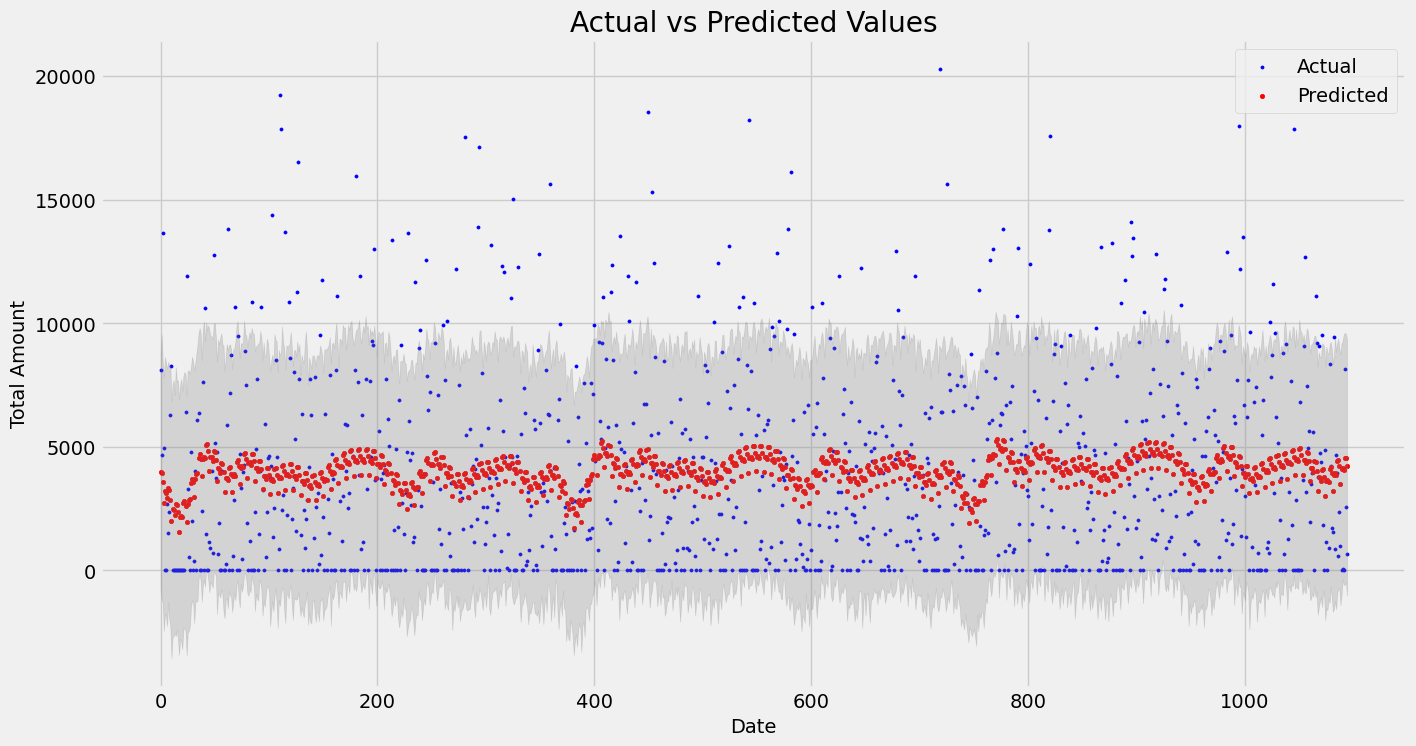

In [24]:
#plot Sales vs Predictions (scatter)
plt.figure(figsize=(15,8))

# Plot the actual data
plt.scatter(merged.index, merged['Total_Amt'], color='blue', label='Actual', s=5)

# Plot the predicted data
plt.scatter(merged.index, merged['yhat'], color='red', label='Predicted', s=10)
# plot the upper and lower boundaries of confidence intervals
plt.fill_between(merged.index, merged['yhat_lower'], merged['yhat_upper'], color='gray', alpha=0.25)

plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.title('Actual vs Predicted Values')
plt.legend()

plt.show()



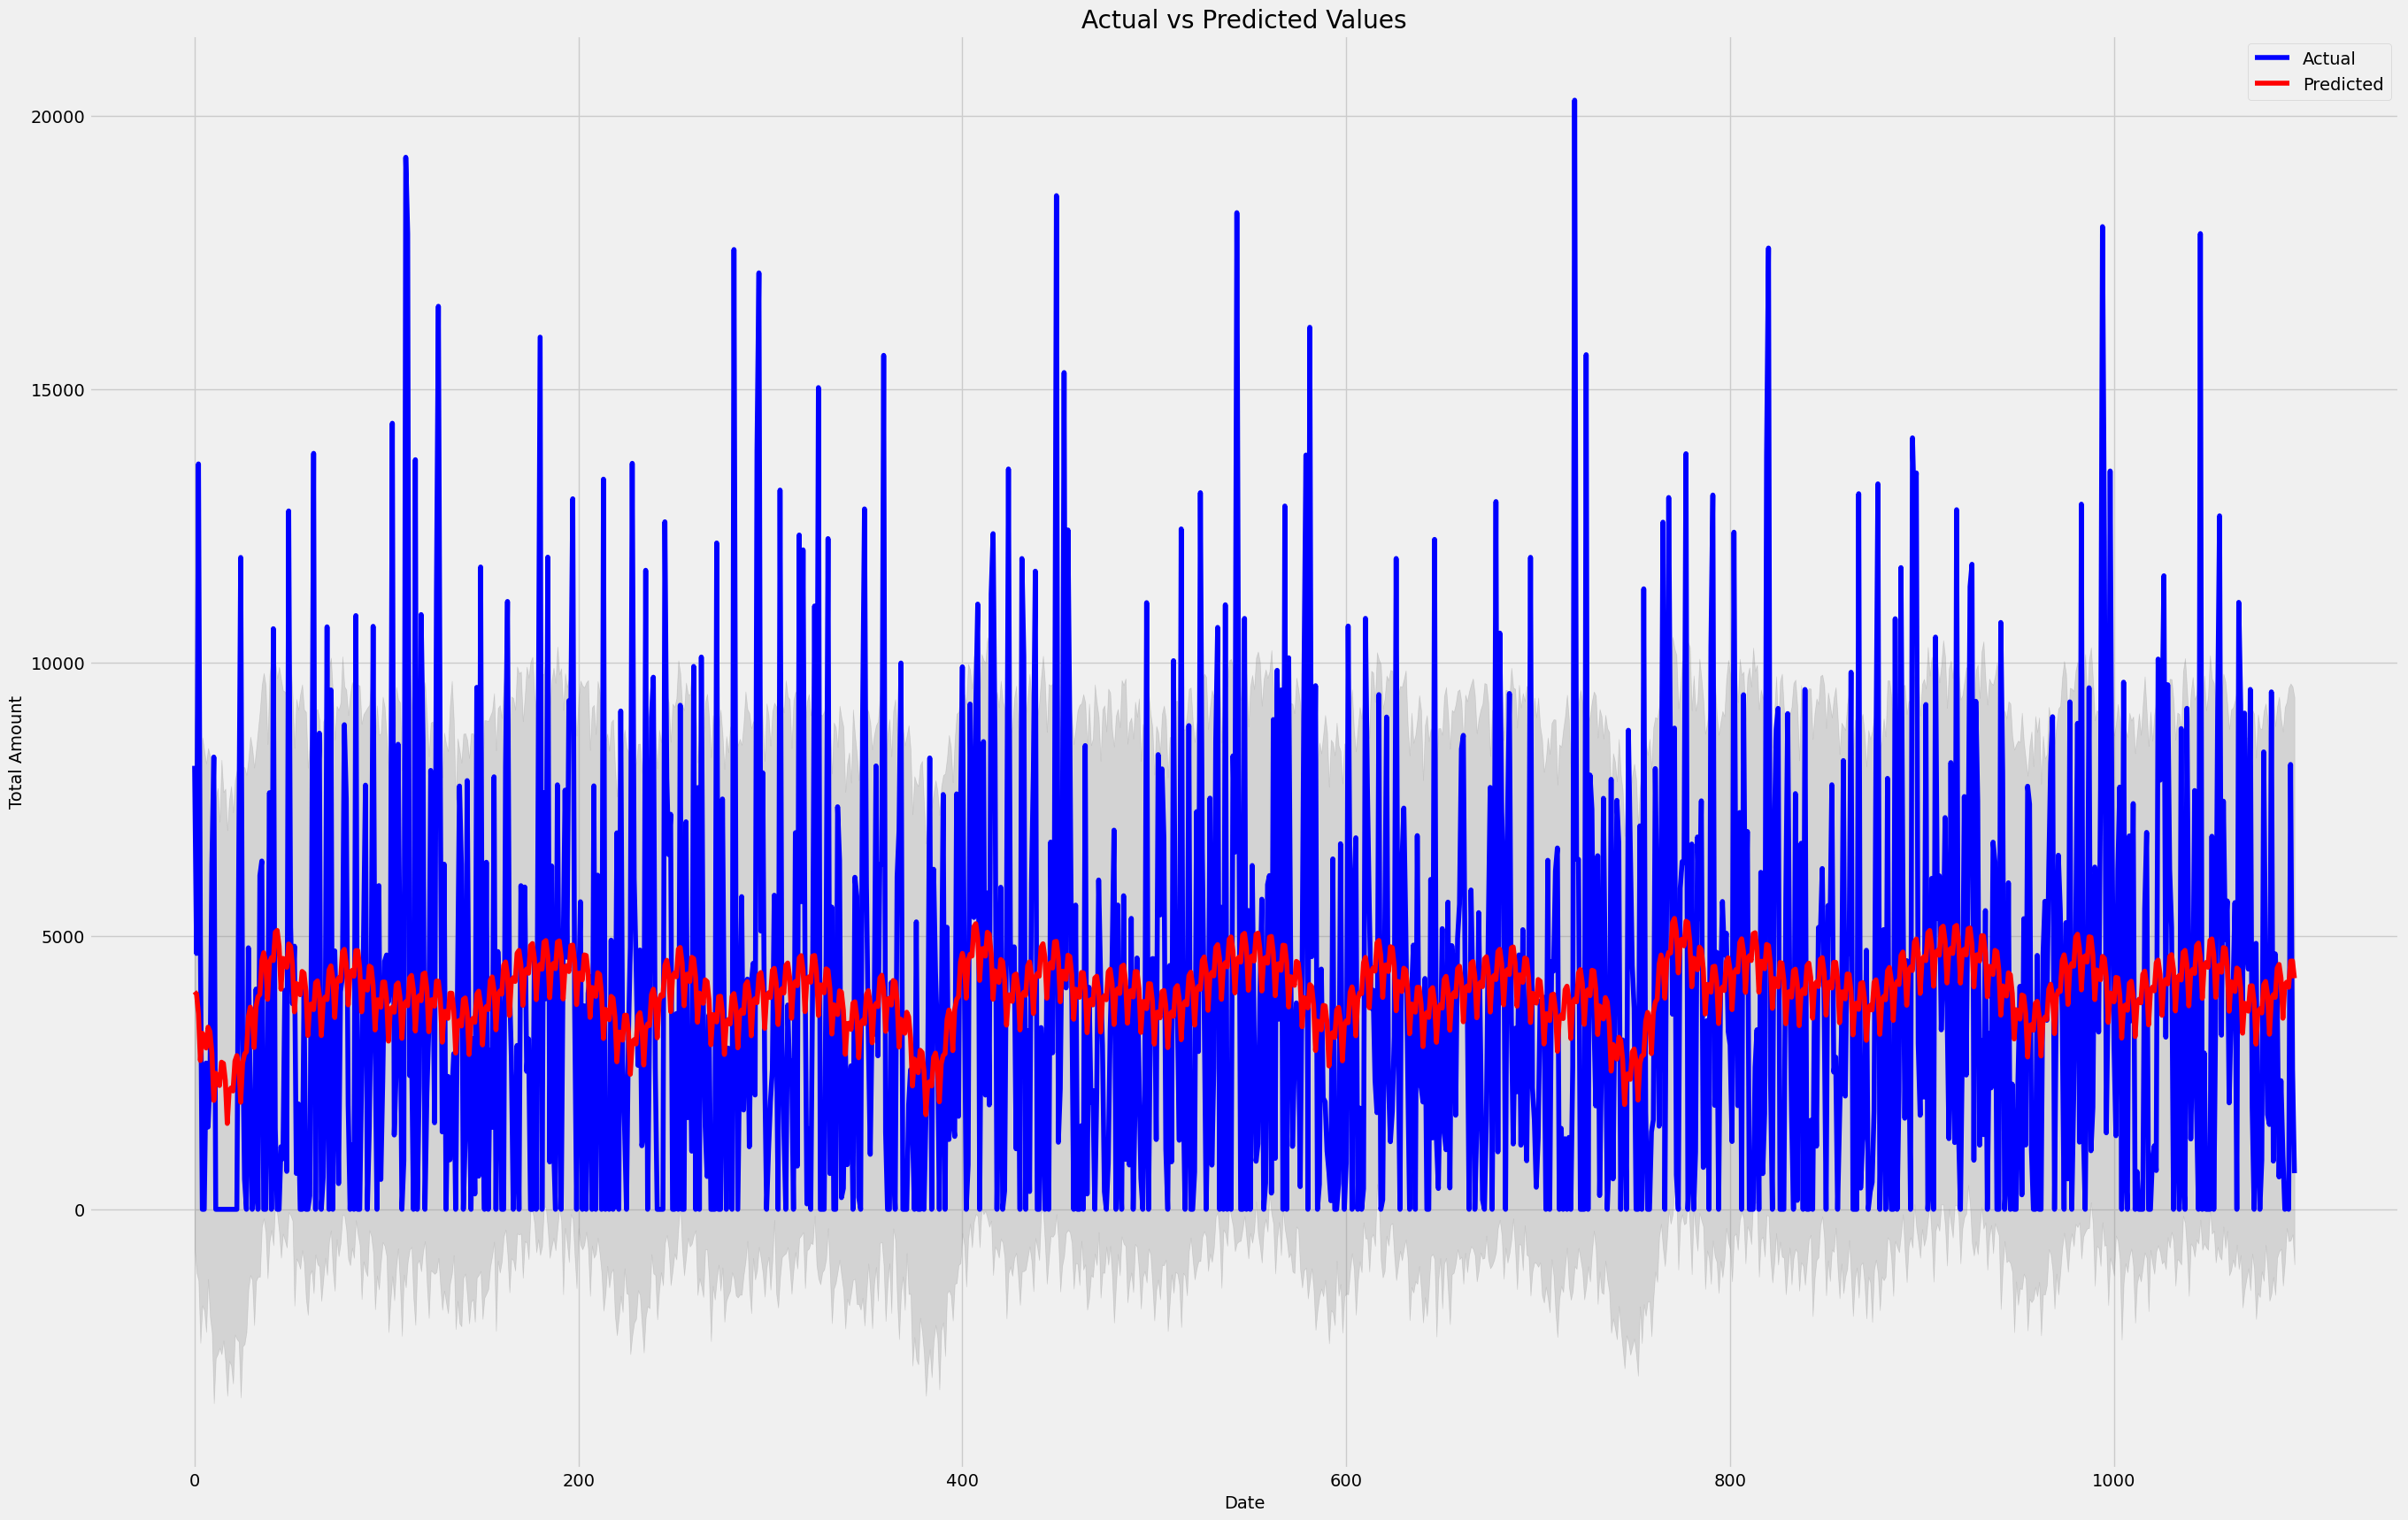

In [25]:
#plot Sales vs Predictions (plot)

plt.figure(figsize=(30,20))

# plot the actual data
plt.plot(merged.index, merged['Total_Amt'], 'b-', label='Actual')

# plot the forecast 
plt.plot(merged.index, merged['yhat'], 'r-', label='Predicted')

# plot the upper and lower boundaries of confidence intervals
plt.fill_between(merged.index, merged['yhat_lower'], merged['yhat_upper'], color='gray', alpha=0.25)

plt.legend()
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.title('Actual vs Predicted Values')

plt.show()

# 6. RMSE calculation
#the average difference between the actual and predicted daily total sales


In [26]:
#to be safe let's make a copy of df "clean_data"
clean_data = df_daily.copy()

In [27]:
#rename Txn_date column to ds for merge
clean_data.rename(columns={'Txn_date': 'ds'}, inplace=True)

In [28]:
#converting df in forecast datase
forecast['ds'] = pd.to_datetime(forecast['ds'])

In [29]:
merged_rmse = pd.merge(forecast, clean_data, on='ds', how='inner')

In [30]:
merged_rmse['diff_squared'] = (merged_rmse['yhat'] - merged_rmse['Total_Amt'])**2

In [31]:
mean_diff_squared = merged_rmse['diff_squared'].mean()

In [32]:
rmse = np.sqrt(mean_diff_squared)
rmse

3963.024095469102

In [33]:
# The difference between actual sales and prediction is almost $4000. 

# 7. Mean vs Forecast
### for comparison let's calculate daily mean of "Total_Amt" and "yhat" (our forecast) and put them on one chart for visual analysis

In [61]:
#upload the dataset
data_no_outliers = pd.read_csv('data_no_outliers.csv', parse_dates=['Txn_date'])

In [62]:
#Calculating daily mean for "Total_Amt"
daily_mean_data = data_no_outliers.groupby('Txn_date')["Total_Amt"].mean()
daily_mean_data

Txn_date
2016-01-02    2614.093696
2016-01-03    2725.942917
2016-01-04    3017.658913
2016-01-05    2746.628182
2016-01-06    2460.575000
                 ...     
2018-12-27    2560.285000
2018-12-28    2552.243056
2018-12-29    2503.500278
2018-12-30    2964.845000
2018-12-31    2416.512222
Name: Total_Amt, Length: 1071, dtype: float64

In [63]:
merged_mean_forecast = pd.merge(left=daily_mean_data.reset_index(), right=forecast[['ds', 'yhat']], left_on='Txn_date',right_on='ds')
merged_mean_forecast 

,Txn_date,Total_Amt,ds,yhat
0,2016-01-02,2614.093696,2016-01-02,3978.532033
1,2016-01-03,2725.942917,2016-01-03,3936.350503
2,2016-01-04,3017.658913,2016-01-04,3577.595224
3,2016-01-05,2746.628182,2016-01-05,2721.403289
4,2016-01-06,2460.575000,2016-01-06,3220.739221
...,...,...,...,...
1066,2018-12-27,2560.285000,2018-12-27,4155.010112
1067,2018-12-28,2552.243056,2018-12-28,4059.866333
1068,2018-12-29,2503.500278,2018-12-29,4539.032496
1069,2018-12-30,2964.845000,2018-12-30,4541.754154


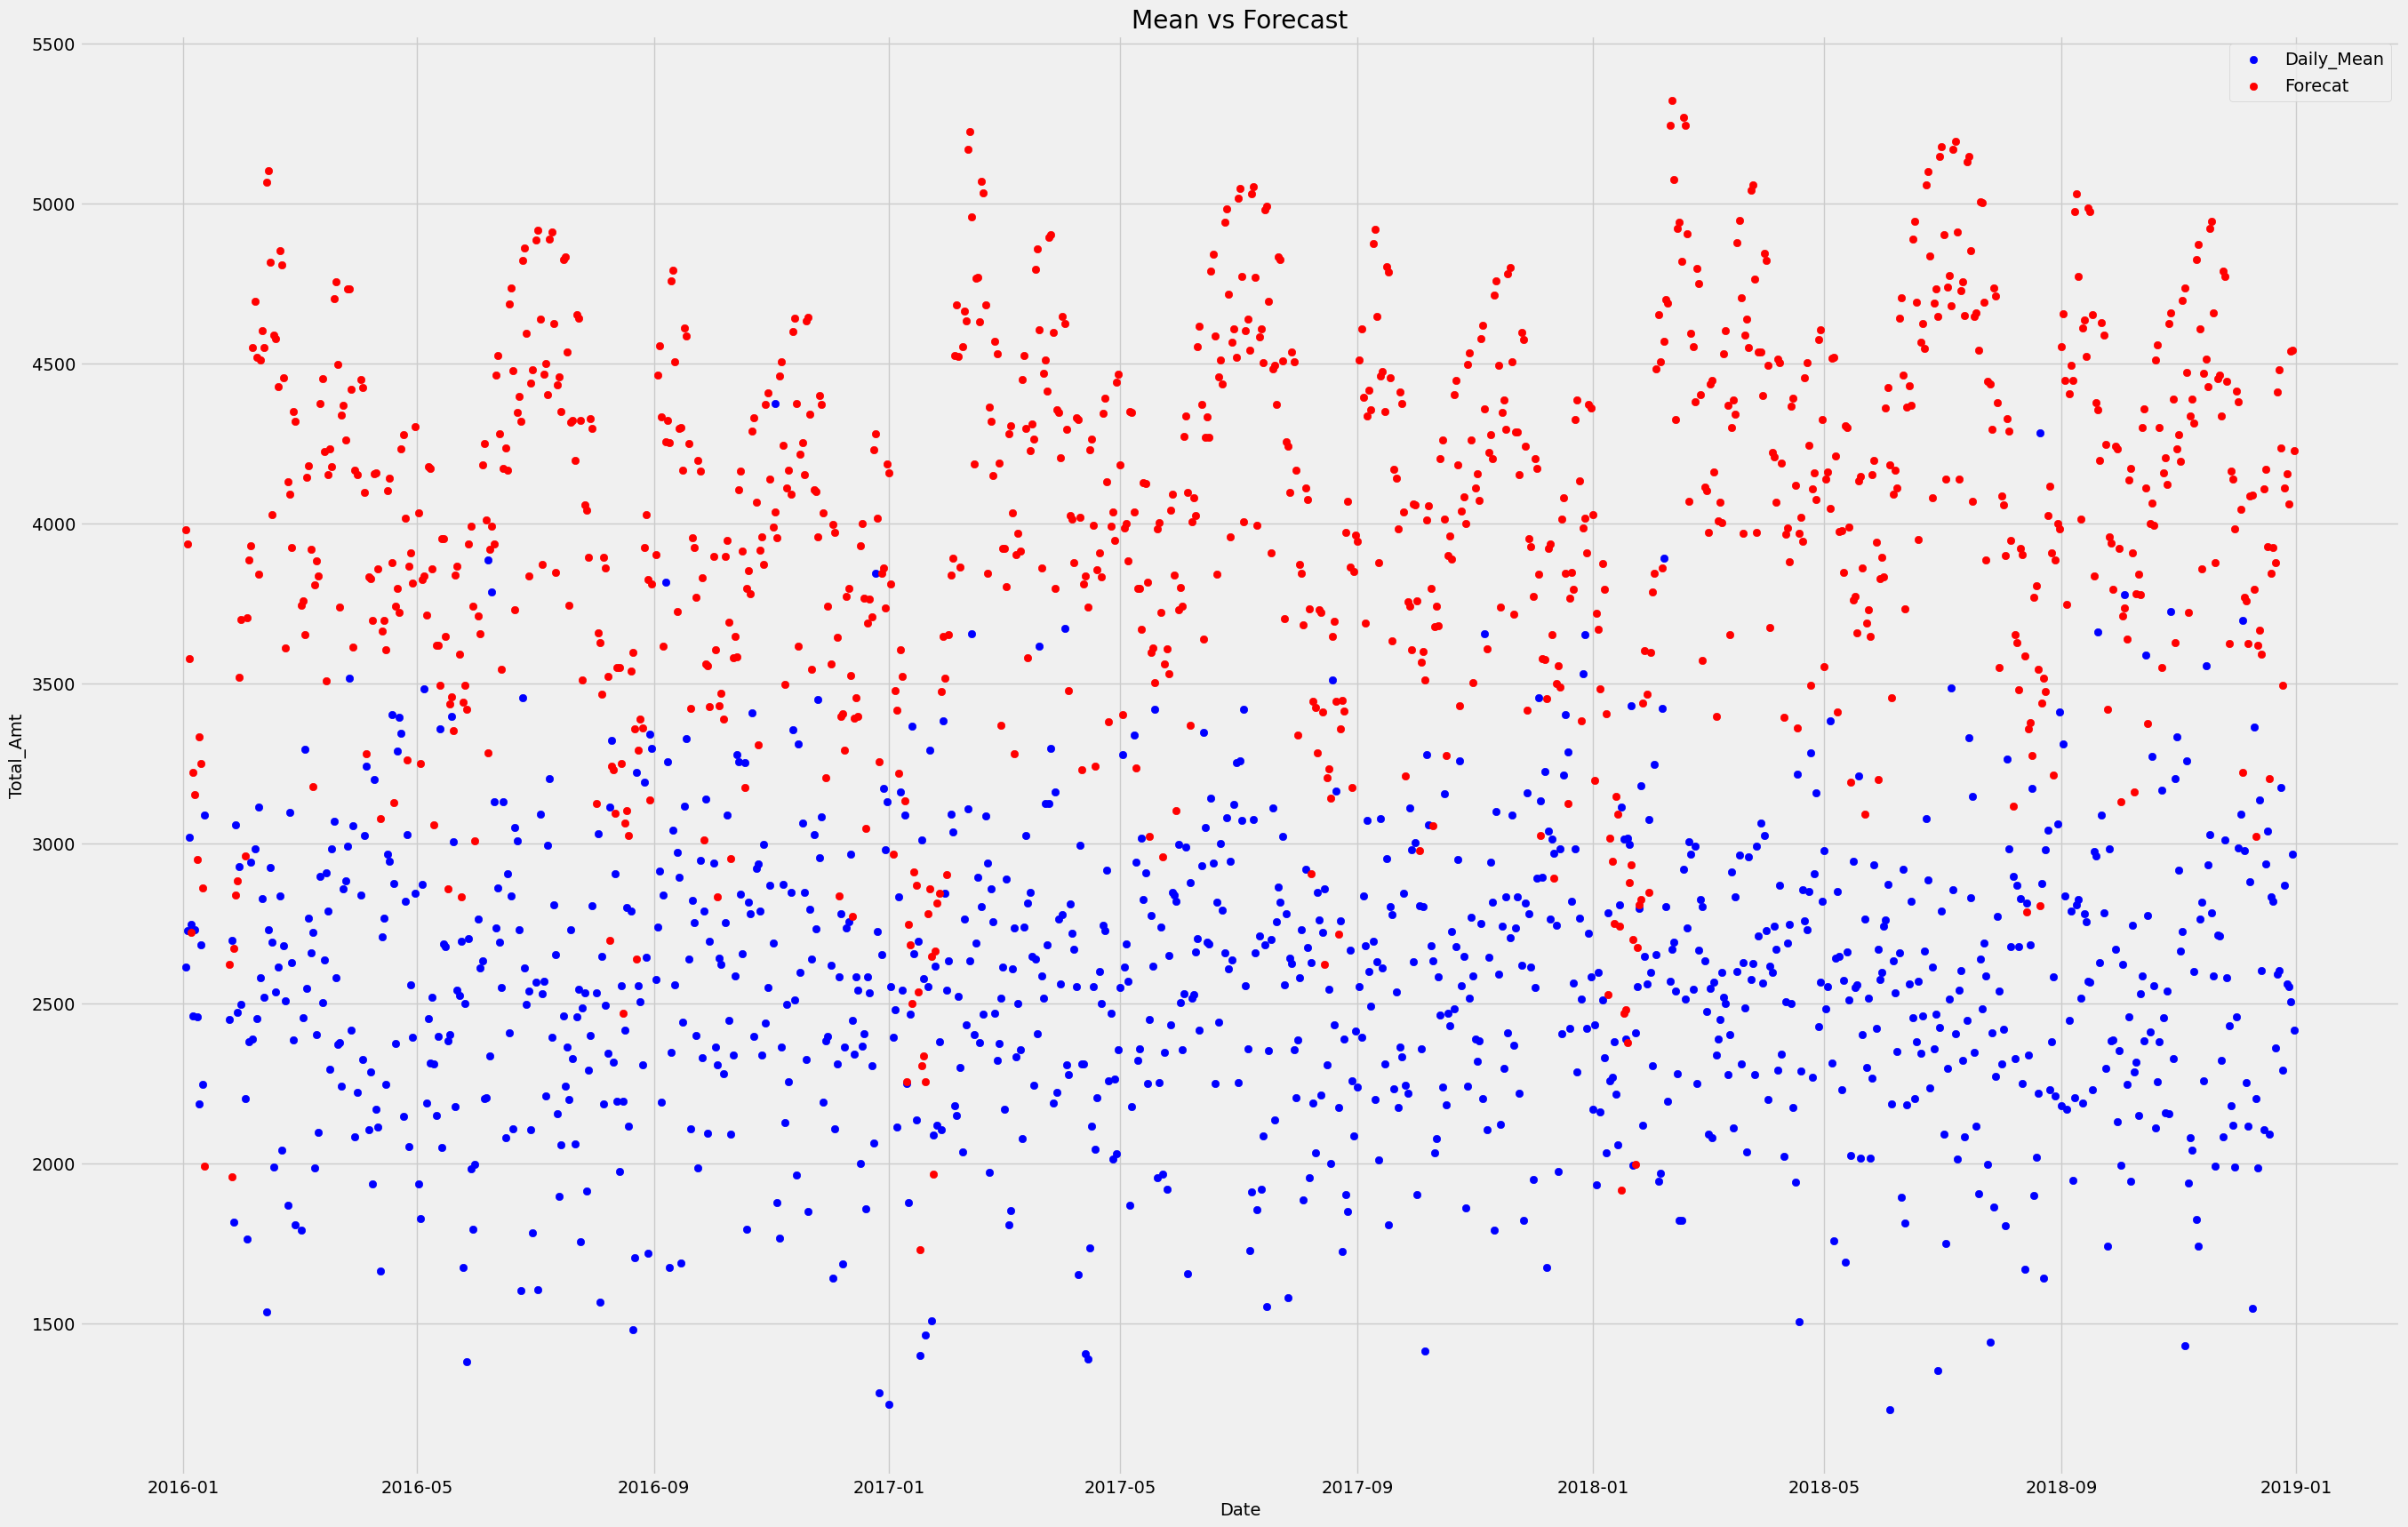

In [37]:
#Chart Scatter
plt.figure(figsize=(30, 20))
plt.scatter(merged_mean_forecast['Txn_date'], merged_mean_forecast['Total_Amt'], label='Daily_Mean', color='blue')
plt.scatter(merged_mean_forecast['Txn_date'], merged_mean_forecast['yhat'], label='Forecat', color='red')
plt.title("Mean vs Forecast")
plt.xlabel("Date")
plt.ylabel("Total_Amt")
plt.legend()
plt.grid(True)
plt.show()

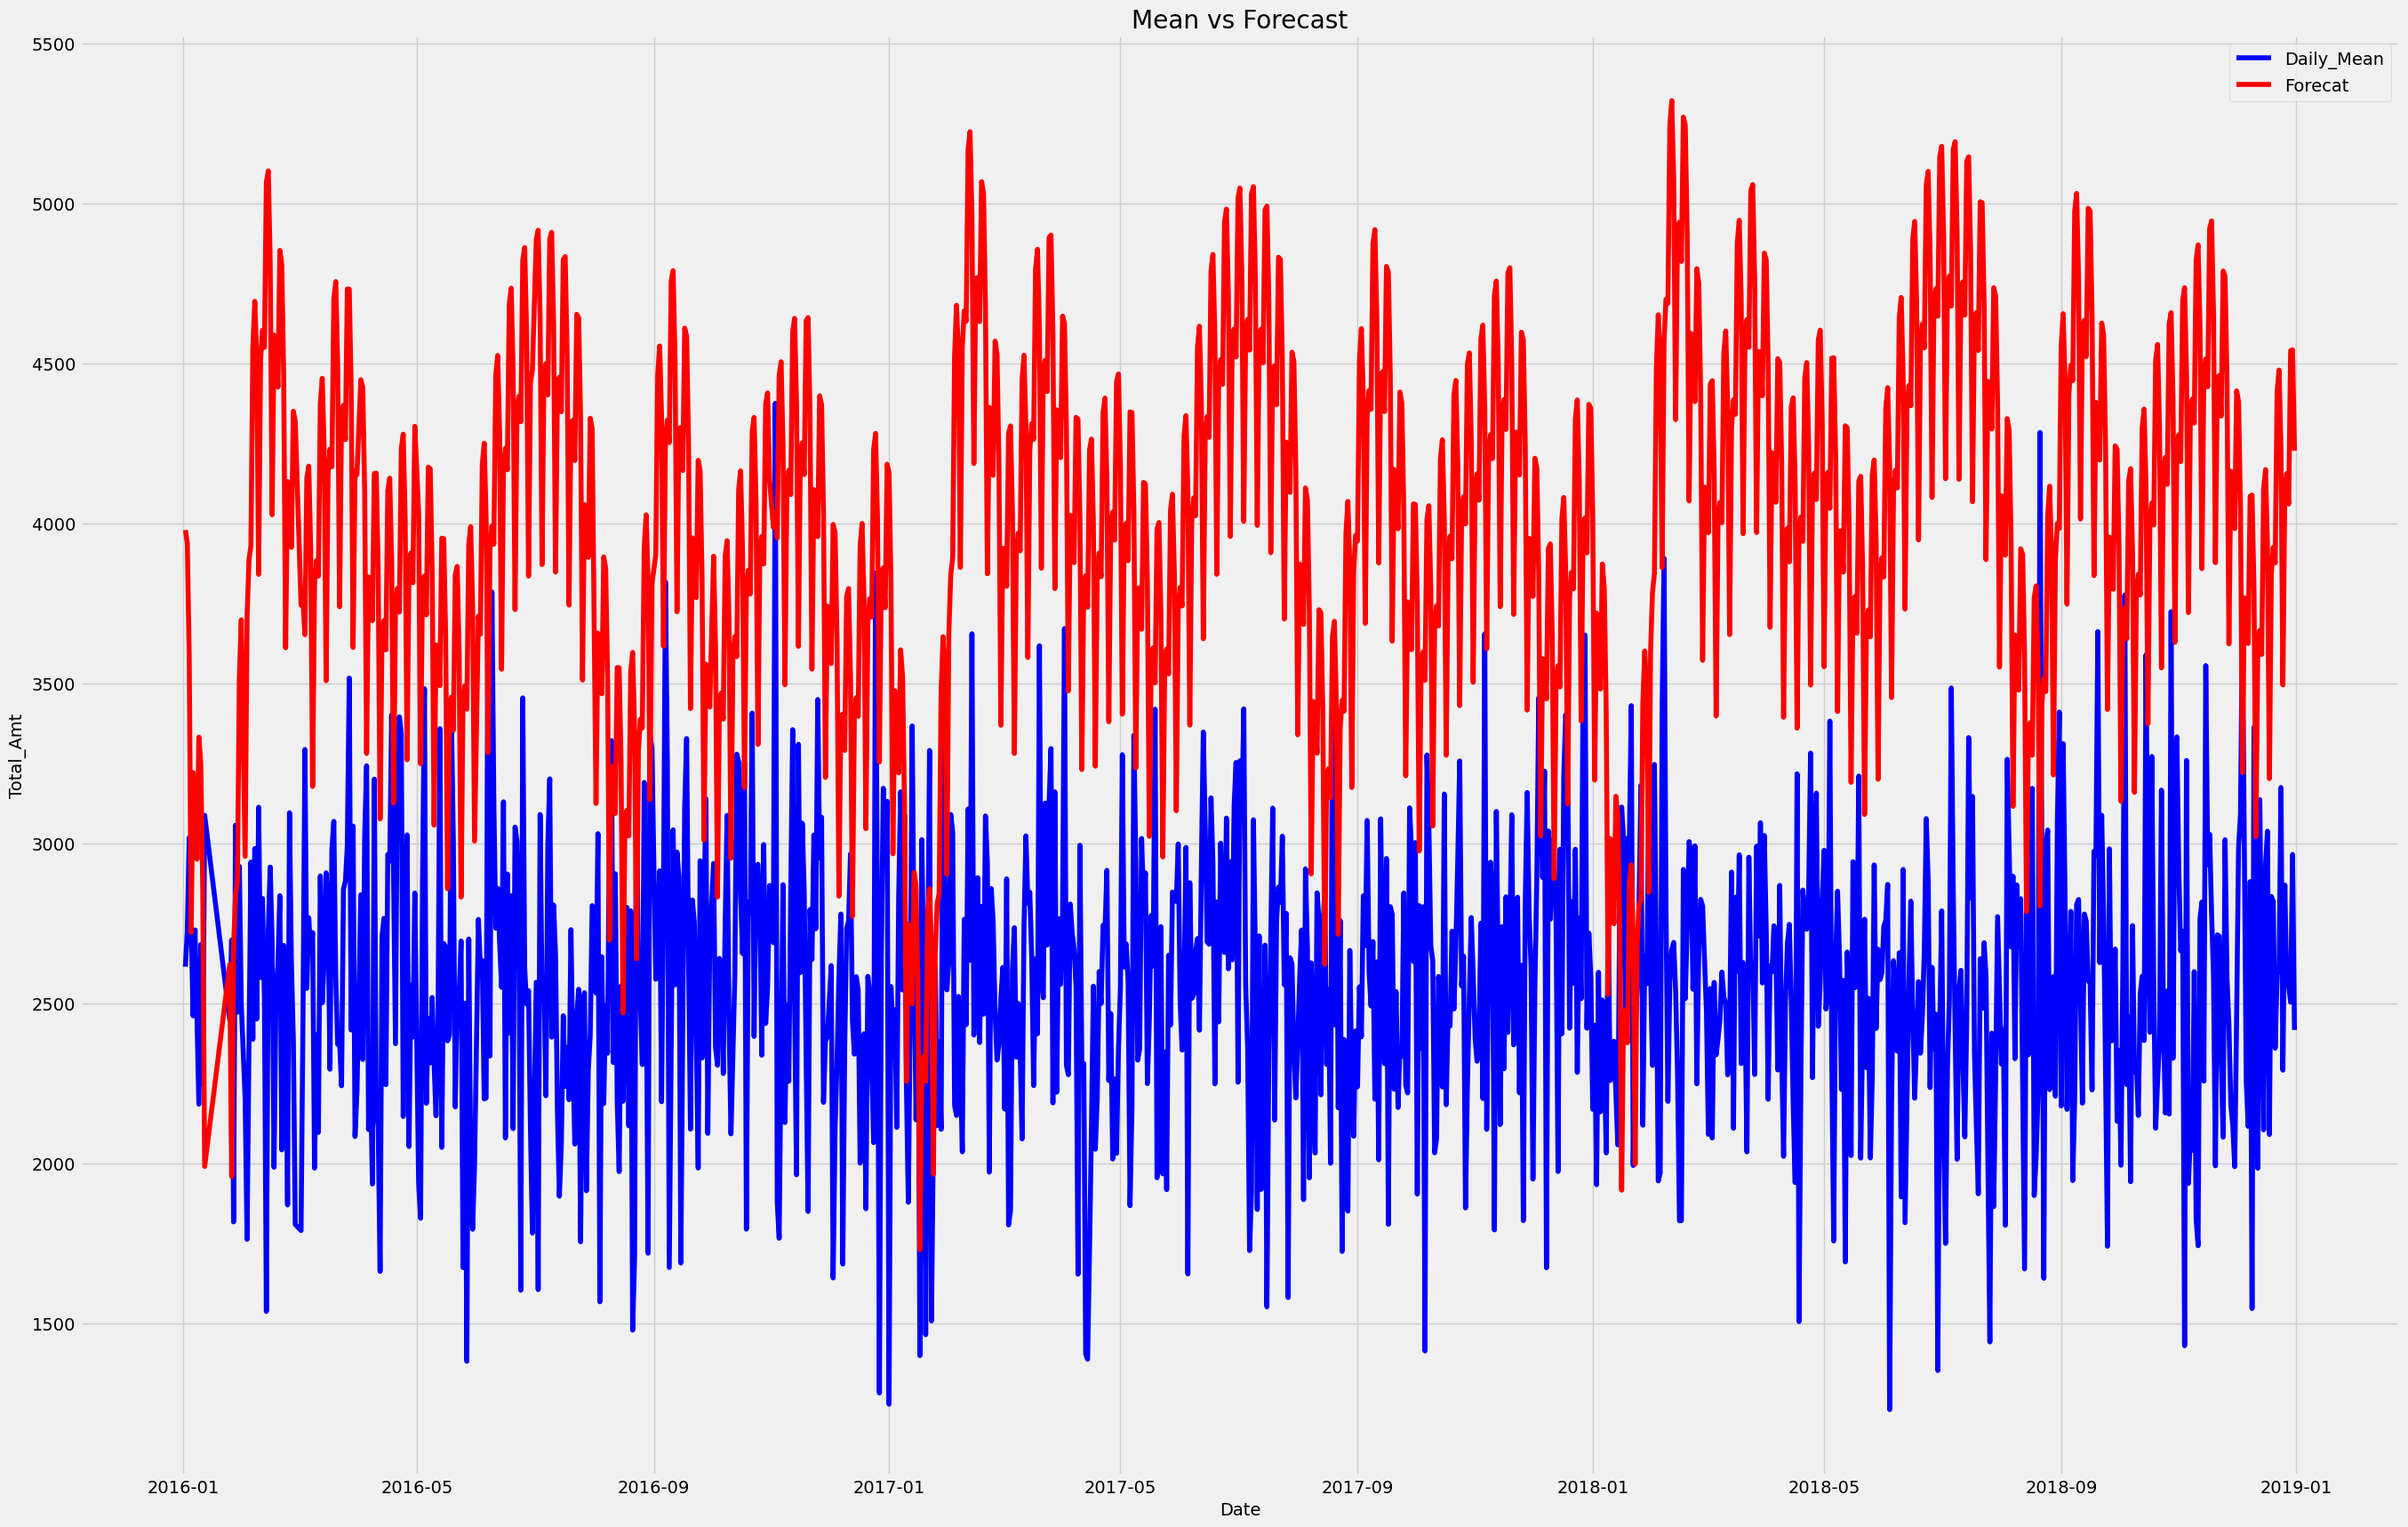

In [38]:
#Plot
plt.figure(figsize=(30, 20))
plt.plot(merged_mean_forecast['Txn_date'], merged_mean_forecast['Total_Amt'], label='Daily_Mean', color='blue')
plt.plot(merged_mean_forecast['Txn_date'], merged_mean_forecast['yhat'], label='Forecat', color='red')
plt.title("Mean vs Forecast")
plt.xlabel("Date")
plt.ylabel("Total_Amt")
plt.legend()
plt.grid(True)
plt.show()

# 8. Summary of comparison mean daily sales and forecast values
The forecast captures a general transaction trend. Also, most of the time the forecast values are not widly off-target. There is some consistency in the forecast which is telling us that model not heavily influenced by noise or big volatility of transactions. But, dispite building the forecast with seasonality we still facing pretty big volatility.

# 9. Modeling, forecasting summary

We have used the Facebook Prophet library to build our forecasting model. This model has been configured to account for daily seasonality. To advance our forecasting efforts, we have generated separate forecasts for each category.

Evaluation of the model: We have utilized the Root Mean Square Error (RMSE) to measure the accuracy of our forecasts.

Challenges: The current forecast does not provide a clear picture. The RMSE (which measures the difference between actual sales and predicted sales) for our forecast is approximately $4000, indicating a substantial discrepancy.

# 10. follow up Aug 11

In [43]:
data_rmse_check = pd.read_csv('data_no_outliers.csv')


In [47]:
data_rmse_check['Total_Amt'].describe()

count    19776.000000
mean      2565.653436
std       1910.700361
min         77.350000
25%       1022.125000
50%       2065.245000
75%       3762.525000
max       8011.250000
Name: Total_Amt, dtype: float64

In [55]:
#RMSE for the mean(as a predictions vs actual)

In [56]:
#Calculating the mean for "Total_Amt"
total_amt_mean = data_rmse_check['Total_Amt'].mean()

total_amt_mean

print("Mean of total transaction each day: ", total_amt_mean)

Mean of total transaction each day:  2565.6534359830093


In [57]:
#Calculating the RMASE for dummy model
error = data_rmse_check['Total_Amt'] - total_amt_mean
rmse_dummy = np.sqrt((error**2).mean())

rmse_dummy
print("RMSE for dummy model: ", rmse_dummy)

RMSE for dummy model:  1910.6520515445245
